In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00


In [3]:
folder = "/content/gdrive/My Drive/BioNLP Project"

Dataset source: https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned?resource=download

In [4]:
#file_ = folder + "/depression_dataset_reddit_cleaned.csv"
file_ = folder + "/shuffled_data.csv"

In [5]:
import csv
import torch.utils

In [6]:
f = open(file_, "r")
csv_f = csv.reader(f)

next(csv_f, None)

['clean_text', 'is_depression']

In [7]:
texts = []
labels_str = []
for i, row in enumerate(csv_f):
  if i < 6000:                                   
    texts.append(row[0])
    labels_str.append(row[1])

In [8]:
labels = [int(label) for label in labels_str]

In [9]:
labels = torch.Tensor(labels).to(torch.int64)

In [10]:
from transformers import BertTokenizer

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
encoding = [tokenizer.encode(text) for text in texts]

Token indices sequence length is longer than the specified maximum sequence length for this model (696 > 512). Running this sequence through the model will result in indexing errors


In [13]:
sizes = [len(enc) for enc in encoding if len(enc)<=512]

In [14]:
import numpy as np

Finding an optimal size for max token length:

In [15]:
max_tokens = np.mean(sizes) + 2 * np.std(sizes)
max_tokens = int(max_tokens)
max_tokens

248

In [16]:
#max_tokens = 512

In [17]:
tok_dict = [tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_tokens,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   ) for text in texts]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
ids = [tok_dict[i]['input_ids'] for i in range(len(tok_dict))] 
token_type_ids = [tok_dict[i]['token_type_ids'] for i in range(len(tok_dict))] 
attention_masks = [tok_dict[i]['attention_mask'] for i in range(len(tok_dict))]

This section is intended for dataset shuffling (the original dataset is half labeled 1, half labeled 0). The shuffled dataset is saved to google drive as "shuffled_data.csv".

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
#train_ex, test_ex, train_label_ex, test_label_ex = train_test_split(texts, labels_str, shuffle=True, test_size=0.1)

In [21]:
#fields = ["clean_text", "is_depression"]

In [22]:
"""
rows = []
for i in range(len(train_label_ex)):
  rows.append([train_ex[i], train_label_ex[i]])

for i in range(len(test_label_ex)):
  rows.append([test_ex[i], test_label_ex[i]])
"""

'\nrows = []\nfor i in range(len(train_label_ex)):\n  rows.append([train_ex[i], train_label_ex[i]])\n\nfor i in range(len(test_label_ex)):\n  rows.append([test_ex[i], test_label_ex[i]])\n'

In [23]:
"""
with open(folder + "/shuffled_data.csv", 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(rows)
"""

'\nwith open(folder + "/shuffled_data.csv", \'w\') as csvfile: \n    # creating a csv writer object \n    csvwriter = csv.writer(csvfile) \n        \n    # writing the fields \n    csvwriter.writerow(fields) \n        \n    # writing the data rows \n    csvwriter.writerows(rows)\n'

Train/test/val split:


In [24]:
train_idx, val_test_idx = train_test_split(
    np.arange(len(labels)),
    test_size = 0.4,               
    shuffle = True)            

In [25]:
labels_left = list(set(np.arange(len(labels))) - set(train_idx))

In [26]:
val_idx, test_idx = train_test_split(
    labels_left,
    test_size = 0.3,           
    shuffle = True)            

In [27]:
import torch.nn.functional as F

In [28]:
labels_onehot = F.one_hot(labels, num_classes=2)            

In [29]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

One-hot encoding the labels:

In [30]:
labels_onehot_res = [torch.reshape(el, 
(1, 2)).to(torch.float) for el in labels_onehot]

Building the data loaders:

In [31]:
train_set = TensorDataset(torch.cat([ids[i] for i in train_idx], dim = 0), 
                          torch.cat([token_type_ids[i] for i in train_idx], dim = 0),
                          torch.cat([attention_masks[i] for i in train_idx], dim=0), 
                          torch.cat([labels_onehot_res[i] for i in train_idx], dim=0))

In [32]:
test_set = TensorDataset(torch.cat([ids[i] for i in test_idx], dim = 0), 
                         torch.cat([token_type_ids[i] for i in test_idx], dim = 0),
                         torch.cat([attention_masks[i] for i in test_idx], dim=0), 
                         torch.cat([labels_onehot_res[i] for i in test_idx], dim=0))

In [33]:
val_set = TensorDataset(torch.cat([ids[i] for i in val_idx], dim = 0), 
                        torch.cat([token_type_ids[i] for i in val_idx], dim = 0), 
                        torch.cat([attention_masks[i] for i in val_idx], dim=0), 
                        torch.cat([labels_onehot_res[i] for i in val_idx], dim=0))

In [34]:
batch_size = 50

In [35]:
train_loader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

In [36]:
test_loader = DataLoader(
            test_set,
            sampler = RandomSampler(test_set),
            batch_size = batch_size
        )

In [37]:
val_loader = DataLoader(
            val_set,
            sampler = RandomSampler(val_set),
            batch_size = batch_size
        )

Building the finetunded model with BERT as a base:

In [38]:
from torch import nn

In [39]:
class BERT_Class(nn.Module):

    def __init__(self, bert, batch_size, input_size, hidden_size, num_layers, dropout=0.2):

      super(BERT_Class, self).__init__()

      self.bert = bert
      self.relu = nn.ReLU()
      self.softmax = nn.Softmax(dim=1)
      # dense layer 1
      self.fc1 = nn.Linear(768,50)
        
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(50,2)
      self.dropout = nn.Dropout(0.2)

      self.fc = nn.Linear(768, 2)
      
    
    def forward(self, ids, token_type_ids, attention_masks):
        _, out1 = self.bert(ids, 
                        token_type_ids = token_type_ids, 
                        attention_mask = attention_masks, return_dict=False)
        
        """
        For 2-layer finetuning:

        out2 = self.relu(out1)
        out3 = self.fc1(out2)
        out3 = self.relu(out3)
        out4 = self.dropout(out3)
        #print(out1)
        out5 = self.fc2(out4)

        """
        out5 = self.fc(out1)  
        return self.softmax(out5)
        

In [40]:
class Args():
  def __init__(self):
      self.test_batch_size = 25
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = 1              
      self.cuda = False
      self.epochs = 15                     

args = Args()

In [41]:
from transformers import BertModel

In [42]:
model_bert = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training and testing:

In [43]:
#In order to fine-tune BERT, we need to make sure that we don't change the weights through backpropagation
for param in model_bert.parameters():
    param.requires_grad = False

In [44]:
model_class = BERT_Class(model_bert, batch_size, 15, 256, 1)

In [53]:
optimizer_class = torch.optim.AdamW(model_class.parameters(), lr = 2e-5, eps = 1e-08)

In [55]:
def train(args, model_, train_loader, optimizer, epoch):
    correct = 0
    model_class.train()
    
    all_losses = []
    num_iter = 0
    for batch_idx, (ids, token_type_ids, attention_masks, target) in enumerate(train_loader):
        optimizer_class.zero_grad()
        output = model_(ids, token_type_ids, attention_masks)        
        loss = nn.functional.binary_cross_entropy(output, target)             #for binary classification
        all_losses.append(loss.detach().numpy())
        pred = output.round()
        correct += pred.eq(target.view_as(pred)).float().mean().item()    
        loss.backward()
        optimizer.step()
        # print the training loss of each batch
        num_iter+=1
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(ids), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    train_accuracy = 100. * correct / num_iter
    return np.array(all_losses).mean(), train_accuracy


def test(args, model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        num_iter = 0
        losses = []
        for ids, token_type_ids, attention_masks, target in test_loader:
            output = model(ids, token_type_ids, attention_masks)
            loss = nn.functional.binary_cross_entropy(output, target)
            losses.append(loss) 
            pred = output.round()
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    test_loss = torch.mean(torch.Tensor(losses))
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy


In [60]:
import matplotlib.pyplot as plt

Plotting the results:

Train Epoch: 1 [0/3600 (0%)]	Loss: 0.684090
Train Epoch: 1 [50/3600 (1%)]	Loss: 0.703510
Train Epoch: 1 [100/3600 (3%)]	Loss: 0.687169
Train Epoch: 1 [150/3600 (4%)]	Loss: 0.696647
Train Epoch: 1 [200/3600 (6%)]	Loss: 0.682575
Train Epoch: 1 [250/3600 (7%)]	Loss: 0.683684
Train Epoch: 1 [300/3600 (8%)]	Loss: 0.692921
Train Epoch: 1 [350/3600 (10%)]	Loss: 0.698460
Train Epoch: 1 [400/3600 (11%)]	Loss: 0.695421
Train Epoch: 1 [450/3600 (12%)]	Loss: 0.710849
Train Epoch: 1 [500/3600 (14%)]	Loss: 0.682059
Train Epoch: 1 [550/3600 (15%)]	Loss: 0.687753
Train Epoch: 1 [600/3600 (17%)]	Loss: 0.679727
Train Epoch: 1 [650/3600 (18%)]	Loss: 0.674119
Train Epoch: 1 [700/3600 (19%)]	Loss: 0.678451
Train Epoch: 1 [750/3600 (21%)]	Loss: 0.681078
Train Epoch: 1 [800/3600 (22%)]	Loss: 0.680151
Train Epoch: 1 [850/3600 (24%)]	Loss: 0.683241
Train Epoch: 1 [900/3600 (25%)]	Loss: 0.683013
Train Epoch: 1 [950/3600 (26%)]	Loss: 0.684408
Train Epoch: 1 [1000/3600 (28%)]	Loss: 0.674607
Train Epoch: 1 [1050/3

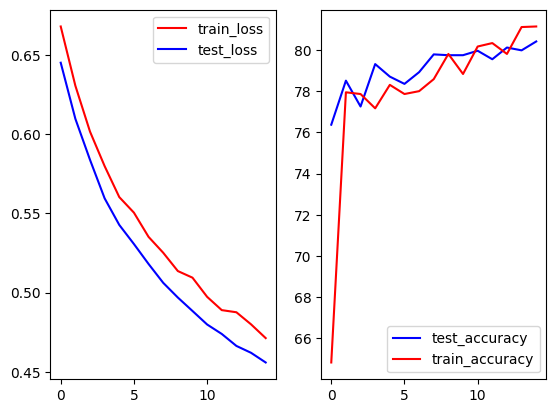

In [61]:
def plot_loss(loss, label, color='blue'):
    plt.plot(loss, label=label, color=color)
    plt.legend()


losses_train = []
losses_test = []
accuracy_test = []
accuracy_train = []
for epoch in range(1, args.epochs + 1):
    train_loss, train_accuracy = train(args, model_class, train_loader, optimizer_class, epoch)
    test_loss, test_accuracy = test(args, model_class, val_loader)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)
    accuracy_train.append(train_accuracy)



#Saving the weights
torch.save(model_class, folder + "/bert_finetuned.pt")


#plot the loss/accuracy    
plt.figure()
plt.subplot(121)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
plt.subplot(122)
plot_loss(accuracy_test,'test_accuracy')
plot_loss(accuracy_train, "train_accuracy", 'red')